In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path ke folder di Google Drive
folder_path = '/content/drive/MyDrive/HAKI/rps'

Mounted at /content/drive


In [3]:
import os

# Path ke folder di Google Drive
folder_path = '/content/drive/MyDrive/HAKI/rps/rockpaperscissors'

# Mendapatkan daftar file di folder
file_list = os.listdir(folder_path)
print("Daftar File:")
for file_name in file_list:
    print(file_name)

Daftar File:
README_rpc-cv-images.txt
paper
scissors
rps-cv-images
rock


In [4]:
import cv2
import os

def threshold_segmentation(image_array):
    _, thresholded = cv2.threshold(image_array, 127, 255, cv2.THRESH_BINARY)
    return thresholded

def suit(direc=folder_path):
    suit_no = []
    IMG_SIZE = 48
    categories = ["paper", "scissors", "rock"]

    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)

        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.COLOR_BGR2GRAY)
            thresholded_array = threshold_segmentation(image_array)

            resized_array = cv2.resize(thresholded_array, (IMG_SIZE, IMG_SIZE))
            suit_no.append([resized_array, class_num1])

    return suit_no


In [5]:
suit48 = suit()

In [6]:
data = len(suit48)
print(data)

2188


In [7]:
x = []
y = []
for feature, label in suit48:
    x.append(feature)
    y.append(label)

In [8]:
x[400].shape
x = np.array(x)
x.reshape(-1,48,48,3)

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0],
         ...,
         [  0, 255,   0],
         [  0, 252,   0],
         [  0,   0,   0]],

        [[  0, 159,   0],
         [  0, 255,   0],
         [  0, 255,   0],
         ...,
         [  0, 255,   0],
         [  0, 167,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0, 162,   0],
        

In [9]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
y = np.array(y)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.4)

In [13]:
print(len(y_train))
print(len(y_test))

1312
876


In [52]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     rotation_range=30)

test_generator = ImageDataGenerator(rescale=1/255)

train_data_generator = train_generator.flow(np.array(x_train), y_train, shuffle=False)
test_data_generator = test_generator.flow(np.array(x_test), y_test, shuffle=False)


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

lenet_model = Sequential()

lenet_model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(48, 48, 3), padding='same'))

lenet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

lenet_model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))

lenet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

lenet_model.add(Flatten())

lenet_model.add(Dense(120, activation='relu'))

lenet_model.add(Dense(84, activation='relu'))

lenet_model.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.0001)
lenet_model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)

lenet_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 6)         456       
                                                                 
 average_pooling2d_2 (Avera  (None, 24, 24, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 10, 10, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_7 (Dense)             (None, 120)              

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

historylenet = lenet_model.fit(x_train, y_train,
                    batch_size=30,
                    epochs=25,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/25
44/44 [==============================] - 10s 157ms/step - loss: 4.1271 - accuracy: 0.5221 - val_loss: 2.4655 - val_accuracy: 0.5822
Epoch 2/25
44/44 [==============================] - 5s 105ms/step - loss: 1.4551 - accuracy: 0.6997 - val_loss: 1.6403 - val_accuracy: 0.6644
Epoch 3/25
44/44 [==============================] - 3s 71ms/step - loss: 0.9010 - accuracy: 0.7744 - val_loss: 1.5241 - val_accuracy: 0.7043
Epoch 4/25
44/44 [==============================] - 3s 68ms/step - loss: 0.6228 - accuracy: 0.8209 - val_loss: 1.2021 - val_accuracy: 0.7352
Epoch 5/25
44/44 [==============================] - 3s 70ms/step - loss: 0.4745 - accuracy: 0.8598 - val_loss: 1.0841 - val_accuracy: 0.7237
Epoch 6/25
44/44 [==============================] - 5s 113ms/step - loss: 0.3721 - accuracy: 0.8811 - val_loss: 1.0035 - val_accuracy: 0.7648
Epoch 7/25
44/44 [==============================] - 4s 98ms/step - loss: 0.2559 - accuracy: 0.9184 - val_loss: 0.9610 - val_accuracy: 0.7728
Epoch 8/2

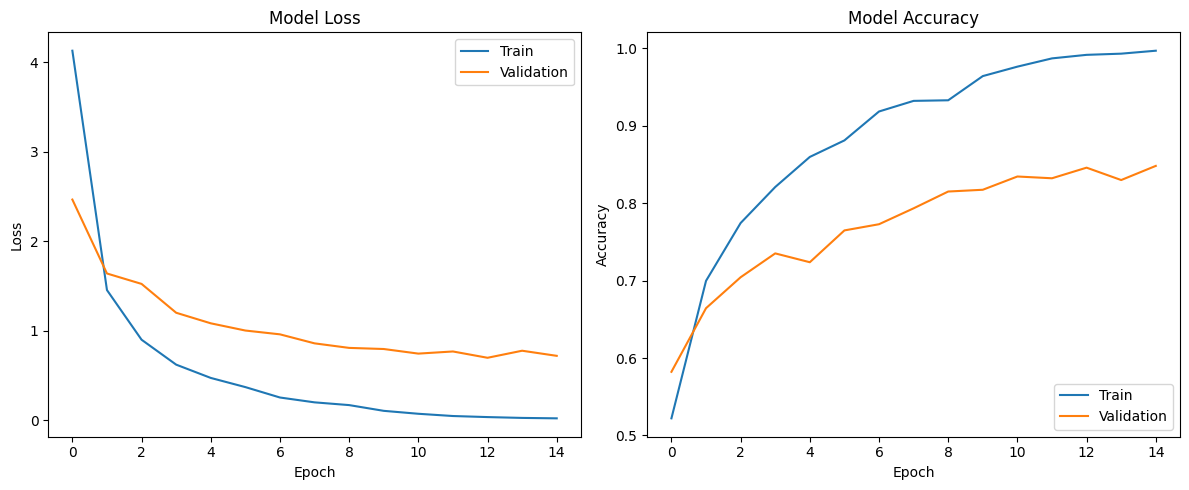

28/28 [==============================] - 3s 70ms/step


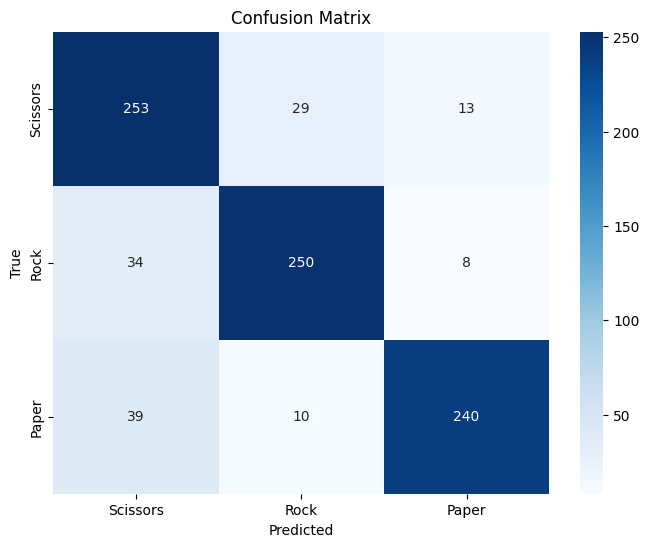

Classification Report:
               precision    recall  f1-score   support

    Scissors       0.78      0.86      0.81       295
        Rock       0.87      0.86      0.86       292
       Paper       0.92      0.83      0.87       289

    accuracy                           0.85       876
   macro avg       0.85      0.85      0.85       876
weighted avg       0.85      0.85      0.85       876



In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(historylenet.history['loss'])
plt.plot(historylenet.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(1, 2, 2)
plt.plot(historylenet.history['accuracy'])
plt.plot(historylenet.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()


y_pred = lenet_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Scissors', 'Rock', 'Paper'],
            yticklabels=['Scissors', 'Rock', 'Paper'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


class_report = classification_report(y_true, y_pred_classes, target_names=['Scissors', 'Rock', 'Paper'])
print("Classification Report:\n", class_report)


Saving eaOtD5yLQHTuFTz3.png to eaOtD5yLQHTuFTz3.png
1/1 [==============================] - 0s 49ms/step


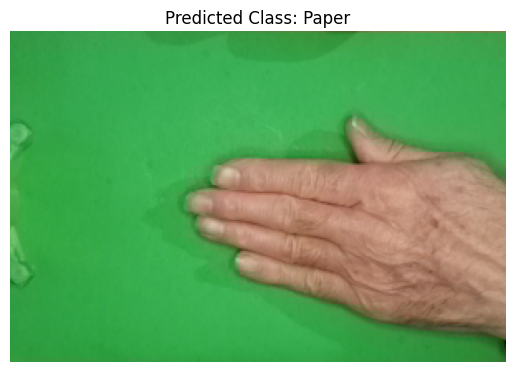

In [51]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np

# Upload an image file
uploaded = files.upload()

# Get the file name
file_name = list(uploaded.keys())[0]

# Load and preprocess the image
img_path = file_name
img = image.load_img(img_path, target_size=(48,48))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values

# Make a prediction
prediction = model1.predict(img_array)
predicted_class = np.argmax(prediction)

# Map class indices to labels
class_labels = ['Paper', 'Rock', 'Scissosrs']
predicted_label = class_labels[predicted_class]

# Display the uploaded image and prediction
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_label}')
plt.show()
